In [44]:
# !!! 런타임 유형 변경 권장 : GPU !!!
# 라이브러리 불러오기
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

# 훈련 위해 장치 환경 설정
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 태스크 수행을 위한 변수 및 하이퍼파라미터 설정
NUM_CLASSES = 10
BATCH_SIZE = 256
NUM_EPOCHS = 10
LEARNING_RATES = {"SGD": 0.1,
                  "Momentum": 0.1,
                  "NAG": 0.1,
                  "Adagrad": 0.01,
                  "Adam": 0.001,
                  "NAdam": 0.002}
num_hidden_layers = 3
num_hidden_neurons = 256


# 데이터셋에 대한 처리 설정
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize((0.5), (0.5))])

# FashionMNIST 데이터셋 불러오기
trainset = torchvision.datasets.FashionMNIST(root='./data',
                                             train=True,
                                             download=True,
                                             transform=transform)
testset = torchvision.datasets.FashionMNIST(root='./data',
                                            train=False,
                                            download=True,
                                            transform=transform)

# 신경망에 데이터를 로드하기 위한 배치 분할 설정
# 입력받은 배치 크기를 참고해서 1epoch에 대한 배치 로더 생성
# len(trainloader) * BATCH_SIZE # 약 6만(훈련 세트 샘플 개수) 정도 나와야 1epoch에 맞게 설정된 것
trainloader = torch.utils.data.DataLoader(trainset, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)

# 분류 클래스 레이블
classes = ('T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
           'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot')

In [45]:
device # cuda : GPU의 병렬 처리 알고리즘에서 범용 계산 기술
# !!! 주의 : 모든 Tensor가 같은 장치 메모리에 있도록 .to(device) 또는 항상 GPU인 경우, .cuda()를 확인

device(type='cuda', index=0)

In [46]:
# 신경망 구조 정의
class Net(nn.Module):
    def __init__(self, num_hidden_layers, num_hidden_neurons): # 은닉층 개수, 각 은닉층 뉴런 개수 입력
        super(Net, self).__init__()
        self.num_hidden_layers = num_hidden_layers
        self.num_hidden_neurons = num_hidden_neurons

        # 입력층 설정
        self.fc1 = nn.Linear(28*28, num_hidden_neurons) # 어파인 변환
        self.activ1 = nn.ReLU() # 활성화 ; nn.ReLU() | nn.GELU() 
        
        # 은닉층 설정 및 ModuleList로 연결
        self.hidden_layers = nn.ModuleList()
        for _ in range(num_hidden_layers):
            self.hidden_layers.append(nn.Linear(num_hidden_neurons, num_hidden_neurons))
            # self.hidden_layers.append(nn.BatchNorm1d(num_hidden_neurons)) # 배치 정규화
            self.hidden_layers.append(nn.ReLU()) # nn.ReLU() | nn.GELU() 
            # self.hidden_layers.append(nn.Dropout(0.1)) # 10% 드롭아웃
        
        # 출력층 설정
        self.fc2 = nn.Linear(num_hidden_neurons, NUM_CLASSES)

        # 784 ==> num_hidden_neurons ==> ... ==> num_hidden_neurons ==> 10

    def forward(self, x): # 순전파
        x = x.view(-1, 28*28) # 입력 데이터의 미니배치

        x = self.activ1(self.fc1(x)) # 입력층 어파인 변환 후 활성화

        for layer in self.hidden_layers: # ModuleList 순서대로,
            x = layer(x) # 은닉층 연산 수행
            
        x = self.fc2(x) # 출력층에서는 어파인 변환만 수행
        
        return x

In [47]:
# 신경망 훈련 함수 정의
def train(net, optimizer, trainloader, criterion):
    net.train() # 훈련 모드

    running_loss = 0.0
    for data in trainloader:
        inputs, labels = data[0].to(device), data[1].to(device)

        optimizer.zero_grad() # 미분 저장 초기화

        outputs = net(inputs) # 훈련
        loss = criterion(outputs, labels)
        loss.backward() # 매개변수에 대한 미분 계산
        optimizer.step() # 미분 값에 의해 매개변수 갱신

        running_loss += loss.item()
    return running_loss / len(trainloader) # 손실 반환

In [48]:
# 신경망 테스트 함수 정의
def test(net, testloader):
    net.eval() # 학습(훈련)과 추론(테스트) 모드가 다름

    correct = 0
    total = 0
    with torch.no_grad(): # 추론 모드에서 미분 계산 제외
        for data in testloader:
            images, labels = data[0].to(device), data[1].to(device)

            outputs = net(images) # 추론
            _, predicted = torch.max(outputs.data, 1) # 가장 큰 예측값의 클래스 레이블만 저장
            total += labels.size(0) # 배치 내 데이터 샘플 개수
            correct += (predicted == labels).sum().item() # 예측 성공 개수

    return 100 * correct / total # 정확도 반환

In [49]:
# 비교를 위한 훈련 및 테스트 함수 병합
from tqdm import tqdm
def train_and_test(optimizer_name, num_hidden_layers, num_hidden_neurons):
    # 새로운 신경망 객체 생성
    net = Net(num_hidden_layers, num_hidden_neurons).to(device)

    # 손실 함수
    criterion = nn.CrossEntropyLoss()
    
    # 옵티마이저 설정
    if optimizer_name == "SGD":
        optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATES["SGD"])
    elif optimizer_name == "Momentum":
        optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATES["Momentum"],
                              momentum=0.9)
    elif optimizer_name == "NAG":
        optimizer = optim.SGD(net.parameters(), lr=LEARNING_RATES["NAG"],
                              momentum=0.9, nesterov=True)
    elif optimizer_name == "Adagrad":
        optimizer = optim.Adagrad(net.parameters(), lr=LEARNING_RATES["Adagrad"])
    elif optimizer_name == "Adam":
        optimizer = optim.Adam(net.parameters(), lr=LEARNING_RATES["Adam"])
    elif optimizer_name == "NAdam":
        optimizer = optim.NAdam(net.parameters(), lr=LEARNING_RATES["NAdam"])
    
    # 학습률 스케쥴러(local minima 탈출 방법론 ; 기본적으로 에포크에 대한 함수)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

    train_losses = [] # 훈련 중 손실 함수 추이
    test_accuracies = [] # 훈련 중 테스트 정확도 추이
    for epoch in tqdm(range(NUM_EPOCHS)):
        train_loss = train(net, optimizer, trainloader, criterion)
        train_losses.append(train_loss)
        test_accuracy = test(net, testloader)
        test_accuracies.append(test_accuracy)
        print(f'train loss : {train_loss} | test accuracy : {test_accuracy}')
        scheduler.step()

    return train_losses, test_accuracies # 손실 추이와 정확도 추이

---------------[실험 요소]---------------
은닉층 개수 : 3
은닉층 뉴런 개수 : 256
에포크 수 : 10
배치 크기 : 256
학습률 : {'SGD': 0.1, 'Momentum': 0.1, 'NAG': 0.1, 'Adagrad': 0.01, 'Adam': 0.001, 'NAdam': 0.002}
SGD(lr=0.1)


 10%|█         | 1/10 [00:13<01:57, 13.06s/it]

train loss : 1.1932575007702442 | test accuracy : 72.58


 20%|██        | 2/10 [00:26<01:44, 13.07s/it]

train loss : 0.5646600219797581 | test accuracy : 78.81


 30%|███       | 3/10 [00:39<01:32, 13.23s/it]

train loss : 0.5465004893059426 | test accuracy : 78.82


 40%|████      | 4/10 [00:52<01:18, 13.14s/it]

train loss : 0.5443105104121756 | test accuracy : 78.86


 50%|█████     | 5/10 [01:05<01:05, 13.16s/it]

train loss : 0.5440761690444135 | test accuracy : 78.86


 60%|██████    | 6/10 [01:18<00:52, 13.07s/it]

train loss : 0.5443886723924191 | test accuracy : 78.86


 70%|███████   | 7/10 [01:31<00:39, 13.11s/it]

train loss : 0.5443272652778219 | test accuracy : 78.86


 80%|████████  | 8/10 [01:45<00:26, 13.20s/it]

train loss : 0.543979426520936 | test accuracy : 78.86


 90%|█████████ | 9/10 [01:58<00:13, 13.15s/it]

train loss : 0.5439281491523094 | test accuracy : 78.86


100%|██████████| 10/10 [02:11<00:00, 13.15s/it]


train loss : 0.5441371855583597 | test accuracy : 78.86
Momentum(lr=0.1)


 10%|█         | 1/10 [00:13<02:01, 13.45s/it]

train loss : 0.9659945706103711 | test accuracy : 82.35


 20%|██        | 2/10 [00:27<01:49, 13.71s/it]

train loss : 0.4093719451985461 | test accuracy : 84.49


 30%|███       | 3/10 [00:40<01:34, 13.56s/it]

train loss : 0.3844021529593366 | test accuracy : 84.48


 40%|████      | 4/10 [00:53<01:20, 13.44s/it]

train loss : 0.3813415570462004 | test accuracy : 84.51


 50%|█████     | 5/10 [01:07<01:07, 13.42s/it]

train loss : 0.38100231442045657 | test accuracy : 84.51


 60%|██████    | 6/10 [01:20<00:53, 13.39s/it]

train loss : 0.3813074673743958 | test accuracy : 84.51


 70%|███████   | 7/10 [01:33<00:40, 13.35s/it]

train loss : 0.3808430534093938 | test accuracy : 84.51


 80%|████████  | 8/10 [01:47<00:26, 13.31s/it]

train loss : 0.38101335193248503 | test accuracy : 84.51


 90%|█████████ | 9/10 [02:00<00:13, 13.23s/it]

train loss : 0.3809555621223247 | test accuracy : 84.51


100%|██████████| 10/10 [02:13<00:00, 13.36s/it]


train loss : 0.3814562113995248 | test accuracy : 84.51
NAG(lr=0.1)


 10%|█         | 1/10 [00:13<02:02, 13.59s/it]

train loss : 0.8607905176091701 | test accuracy : 82.18


 20%|██        | 2/10 [00:27<01:48, 13.62s/it]

train loss : 0.38646740634390647 | test accuracy : 85.18


 30%|███       | 3/10 [00:40<01:33, 13.34s/it]

train loss : 0.3641685332389588 | test accuracy : 85.31


 40%|████      | 4/10 [00:53<01:20, 13.42s/it]

train loss : 0.3616747021041018 | test accuracy : 85.22


 50%|█████     | 5/10 [01:07<01:07, 13.55s/it]

train loss : 0.3612580379907121 | test accuracy : 85.21


 60%|██████    | 6/10 [01:20<00:53, 13.38s/it]

train loss : 0.36099511334236634 | test accuracy : 85.21


 70%|███████   | 7/10 [01:33<00:40, 13.34s/it]

train loss : 0.3609848161327078 | test accuracy : 85.21


 80%|████████  | 8/10 [01:47<00:26, 13.28s/it]

train loss : 0.3611502778022847 | test accuracy : 85.21


 90%|█████████ | 9/10 [02:00<00:13, 13.29s/it]

train loss : 0.36152329952158824 | test accuracy : 85.21


100%|██████████| 10/10 [02:13<00:00, 13.36s/it]


train loss : 0.3610936022185265 | test accuracy : 85.21
Adagrad(lr=0.01)


 10%|█         | 1/10 [00:14<02:08, 14.33s/it]

train loss : 0.6660960177157788 | test accuracy : 81.7


 20%|██        | 2/10 [00:27<01:49, 13.72s/it]

train loss : 0.396371595276163 | test accuracy : 84.55


 30%|███       | 3/10 [00:40<01:34, 13.53s/it]

train loss : 0.3844854857059235 | test accuracy : 84.63


 40%|████      | 4/10 [00:54<01:20, 13.47s/it]

train loss : 0.3833658607716256 | test accuracy : 84.63


 50%|█████     | 5/10 [01:07<01:07, 13.55s/it]

train loss : 0.3836424989269135 | test accuracy : 84.63


 60%|██████    | 6/10 [01:21<00:54, 13.54s/it]

train loss : 0.3837822127849498 | test accuracy : 84.63


 70%|███████   | 7/10 [01:35<00:40, 13.56s/it]

train loss : 0.38337666963009126 | test accuracy : 84.63


 80%|████████  | 8/10 [01:49<00:27, 13.82s/it]

train loss : 0.3830446919228168 | test accuracy : 84.63


 90%|█████████ | 9/10 [02:02<00:13, 13.68s/it]

train loss : 0.38348150354750615 | test accuracy : 84.63


100%|██████████| 10/10 [02:16<00:00, 13.62s/it]


train loss : 0.38334037560097717 | test accuracy : 84.63
Adam(lr=0.001)


 10%|█         | 1/10 [00:13<02:00, 13.39s/it]

train loss : 0.6195444690420272 | test accuracy : 83.71


 20%|██        | 2/10 [00:26<01:46, 13.29s/it]

train loss : 0.3791523720355744 | test accuracy : 85.41


 30%|███       | 3/10 [00:39<01:33, 13.33s/it]

train loss : 0.36298035414929086 | test accuracy : 85.72


 40%|████      | 4/10 [00:53<01:19, 13.28s/it]

train loss : 0.3608931294147004 | test accuracy : 85.75


 50%|█████     | 5/10 [01:07<01:08, 13.68s/it]

train loss : 0.36108020861098106 | test accuracy : 85.75


 60%|██████    | 6/10 [01:20<00:54, 13.56s/it]

train loss : 0.36084927979935993 | test accuracy : 85.74


 70%|███████   | 7/10 [01:34<00:40, 13.56s/it]

train loss : 0.3606991186420968 | test accuracy : 85.74


 80%|████████  | 8/10 [01:47<00:27, 13.55s/it]

train loss : 0.360578727088076 | test accuracy : 85.74


 90%|█████████ | 9/10 [02:01<00:13, 13.65s/it]

train loss : 0.3604578368207242 | test accuracy : 85.74


100%|██████████| 10/10 [02:15<00:00, 13.54s/it]


train loss : 0.3604854682658581 | test accuracy : 85.74
NAdam(lr=0.002)


 10%|█         | 1/10 [00:13<02:02, 13.61s/it]

train loss : 0.651444843221218 | test accuracy : 78.82


 20%|██        | 2/10 [00:28<01:54, 14.37s/it]

train loss : 0.3711926764630257 | test accuracy : 85.89


 30%|███       | 3/10 [00:42<01:37, 14.00s/it]

train loss : 0.34627836581240307 | test accuracy : 85.97


 40%|████      | 4/10 [00:55<01:22, 13.74s/it]

train loss : 0.3438103866703967 | test accuracy : 85.98


 50%|█████     | 5/10 [01:08<01:08, 13.62s/it]

train loss : 0.3441884849933868 | test accuracy : 85.98


 60%|██████    | 6/10 [01:22<00:53, 13.50s/it]

train loss : 0.3433257433328223 | test accuracy : 85.98


 70%|███████   | 7/10 [01:35<00:40, 13.46s/it]

train loss : 0.3434508704758705 | test accuracy : 85.98


 80%|████████  | 8/10 [01:48<00:26, 13.46s/it]

train loss : 0.3436375307275894 | test accuracy : 85.98


 90%|█████████ | 9/10 [02:03<00:13, 13.74s/it]

train loss : 0.3435292554662583 | test accuracy : 85.98


100%|██████████| 10/10 [02:16<00:00, 13.67s/it]

train loss : 0.3436093270144564 | test accuracy : 85.98


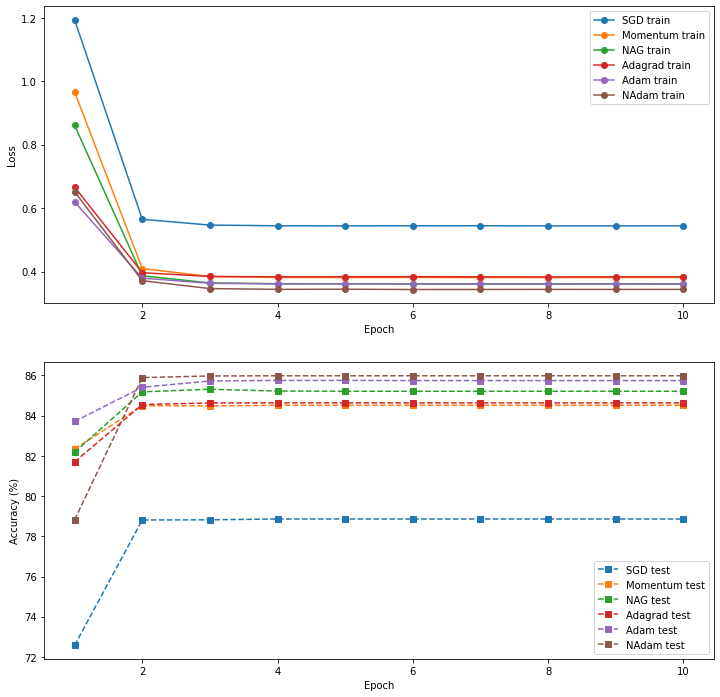

In [50]:
# 각 옵티마이저별 수행
optimizers = ["SGD", "Momentum", "NAG", "Adagrad", "Adam", "NAdam"]

print('---------------[실험 요소]---------------',
      f'은닉층 개수 : {num_hidden_layers}',
      f'은닉층 뉴런 개수 : {num_hidden_neurons}',
      f'에포크 수 : {NUM_EPOCHS}',
      f'배치 크기 : {BATCH_SIZE}',
      f'학습률 : {LEARNING_RATES}',
      '='*39,
      sep='\n')

fig, axes = plt.subplots(2,1,figsize=(12,12))

for i, optimizer_name in enumerate(optimizers):
    print(optimizer_name+f'(lr={LEARNING_RATES[optimizer_name]})')
    train_losses, test_accuracies = train_and_test(optimizer_name,
                                                   num_hidden_layers,
                                                   num_hidden_neurons)
    axes[0].plot(range(1, NUM_EPOCHS+1), train_losses,
                 marker='o', color=f'C{i}', label=optimizer_name+" train")
    axes[1].plot(range(1, NUM_EPOCHS+1), test_accuracies,
                 marker='s', color=f'C{i}', label=optimizer_name+" test", linestyle='dashed')

axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].legend(loc='upper right')

axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].legend(loc='lower right')

plt.show()